In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os
import sys
sys.path.append("/home/muncok/DL/projects/sv_system/")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import itertools
import torch
from dnn.sv_score import sv_score
from dnn.train.model import init_protonet, init_seed
from dnn.data.dataloader import init_sv_loaders
from dnn.parser import get_sv_parser

In [3]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

In [4]:
def secToSample(sec):
    return int(16000 * sec)

In [5]:
options = get_sv_parser().parse_args(args=["-cTr=5", "-cVa=5"])
options.n_dct_filters = 40
options.n_mels = 40
options.timeshift_ms = 100
options.data_folder = "/home/muncok/DL/dataset/SV_sets"
options.window_size= 0.025
options.window_stride= 0.010
options.cache_size = 32768
options.input_format = "mfcc"
init_seed(options)

###  SV Scoring

In [8]:
options.train_manifest = "manifests/voxc/voxc_manifest.csv"
options.val_manifest = "manifests/reddots/si_reddots_train_manifest.csv"

In [9]:
options.input = "models/voxc/si_voxc_0.2s_random.pt"
model = init_protonet(options)

models/voxc/si_voxc_0.2s_random.pt is loaded


In [10]:
input_uttrs_sec = 3
options.input_length = secToSample(input_uttrs_sec)
options.splice_length = secToSample(0.2)
options.num_query_val = 10
enroll_length = 15
options.num_support_val = int(enroll_length/input_uttrs_sec)
options.iterations = 100  # episodes

In [11]:
test_uttrs_lens = [0.2, 0.5, 1, 2, 3]
splice_lens = [0.2, 0.5]
conditions = itertools.product(test_uttrs_lens, splice_lens)

In [12]:
results = dict()
for test_uttrs_l, splice_l in conditions:
    if splice_l > test_uttrs_l: continue
    print("test_uttrs_len:{}, splice_len:{}".format(test_uttrs_l, splice_l))
    # fixing the enrollment speech duration
    options.num_test_frames = int(test_uttrs_l/splice_l)
    options.splice_length = secToSample(splice_l)
    _, val_dataloader = init_sv_loaders(options)
    lda = pickle.load(open("../../models/lda/lda_voxc_{}.pkl".format(splice_l), "rb"))
    results[(test_uttrs_l, splice_l)] = \
        sv_score(options, val_dataloader, model, ["full","diff", "random", "std"], lda)

test_uttrs_len:0.2, splice_len:0.2


FileNotFoundError: [Errno 2] No such file or directory: 'manifests/voxc/voxc_manifest.csv'

In [174]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = len(results)
group_names = list(results[list(results.keys())[0]].keys())

x = dict()
err = dict()
for grp in group_names:
    x[grp], err[grp] = list(zip(*(v[grp] for k,v in results.items())))

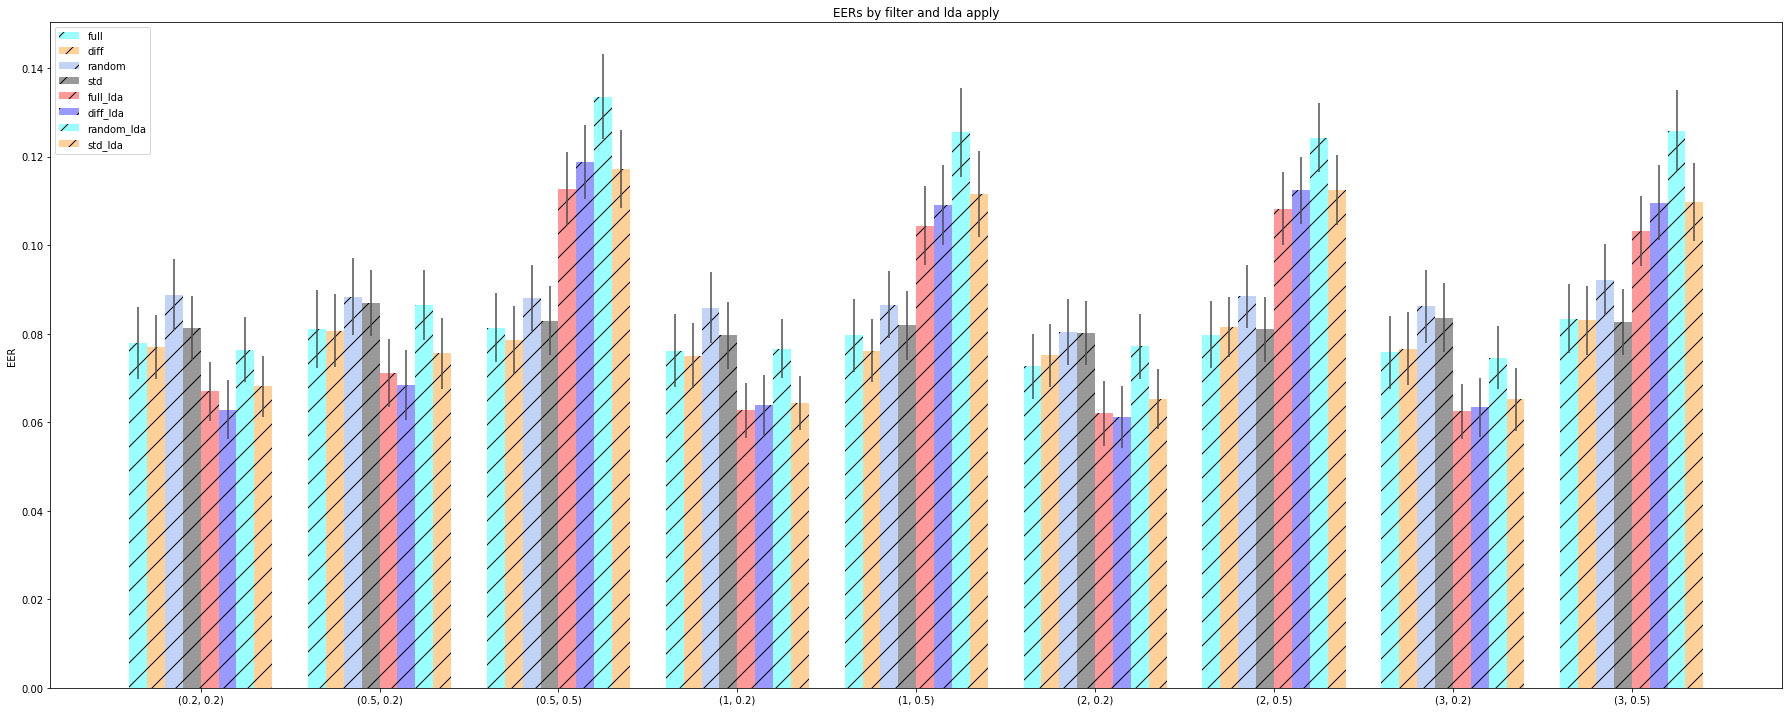

In [180]:
from itertools import cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'black', 'red', 'blue'])
fig, ax = plt.subplots(figsize=(25,10))

index = np.arange(n_groups)
bar_width = 0.1

opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, (grp, color) in enumerate(zip(group_names, colors)): 
    rects1 = ax.bar(index + i*bar_width, x[grp], bar_width,
                    alpha=opacity, color=color,
                    yerr=err[grp], error_kw=error_config,
                    label=grp)

ax.set_ylabel('EER')
ax.set_title('EERs by filter and lda apply')
ax.set_xticks(index + bar_width * (n_groups-2)/2)
ax.set_xticklabels([k for k in results.keys()])
ax.legend()

fig.tight_layout()
plt.show()